In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider, Layout

In [2]:
def system_of_odes(
    y, t, 
    k_HIF_production_basal=0.02, 
    k_HIF_production_max=0.9, 
    k_HIF_pos_feedback=1,
    k_HIF_deg_basal=0.2, 
    k_HIF_deg_lactate=1, 
    k_lactate_production=0.01,
    k_lactate_production_reg=1, 
    k_lactate_deg_basal=0.01,
    k_GFP_production_constantFP_production=1, 
    k_GFP_production_constant=0.05,
    k_GFP_deg=0.1, 
    k_MCT1=1E-3, 
    k_MCT4=1E-3, 
    o2_response_scaling=1.0,
    kmax_o2_deg=1e-1, 
    k_min_o2_deg=1e-2, 
    conc_conversion_oxygen=1.0,
    conc_conversion_lactate=1.0
):
    # Unpack variables
    hif_in, lactate_in, gfp_in, oxygen_ex, lactate_ex = y
    
    # System equations
    hif_production = (k_HIF_production_basal + 
                      k_HIF_production_max * hif_in ** 2 / 
                      (k_HIF_pos_feedback + hif_in ** 2))
    hif_degradation = (k_HIF_deg_basal * hif_in * oxygen_ex + 
                       k_HIF_deg_lactate * hif_in * lactate_in)
    dHIF = hif_production - hif_degradation
    
    lactate_production = (k_lactate_production * hif_in ** 2 / 
                          (k_lactate_production_reg + hif_in ** 2))
    lactate_degradation = k_lactate_deg_basal * lactate_in
    lactate_transport = k_MCT1 * lactate_ex - k_MCT4 * lactate_in
    dLactate = lactate_production - lactate_degradation + lactate_transport
    
    gfp_production = (k_GFP_production_constantFP_production * hif_in ** 3 / 
                      (k_GFP_production_constant + hif_in ** 3))
    gfp_degradation = k_GFP_deg * gfp_in
    dGFP = gfp_production - gfp_degradation
    
    dO2_ext = 0
    if oxygen_ex > 0:
        dO2_ext = -o2_response_scaling * (k_min_o2_deg + kmax_o2_deg / (hif_in + 1))
    
    # Convert from concentration to counts (or vice versa)
    dO2_ext *= conc_conversion_oxygen
    dLactate_ext = -lactate_transport * conc_conversion_lactate
    
    return [
        dHIF, 
        dLactate, 
        dGFP, 
        0,
        0
        # dO2_ext, 
        # dLactate_ext
    ]

In [47]:
def plot_ode_solution(t, solution):
    # Unpack the solution
    hif_in, lactate_in, gfp_in, oxygen_ex, lactate_ex = solution.T  # Transpose to unpack by columns

    # Create the plots
    plt.figure(figsize=(5, 5))

    # Plot HIF
    plt.subplot(3, 1, 1)
    plt.plot(t, hif_in, label='HIF')
    plt.xlabel('Time')
    plt.ylabel('HIF conc')
    # plt.title('HIF Over Time')
    # plt.legend()

    # Plot internal Lactate
    plt.subplot(3, 1, 2)
    plt.plot(t, lactate_in, label='Lactate (internal)')
    plt.xlabel('Time')
    plt.ylabel('Lactate conc')
    # plt.title('Internal Lactate Over Time')
    # plt.legend()

    # Plot GFP
    plt.subplot(3, 1, 3)
    plt.plot(t, gfp_in, label='GFP')
    plt.xlabel('Time')
    plt.ylabel('GFP conc')
    # plt.title('GFP Over Time')
    # plt.legend()

    # # Plot external Oxygen
    # plt.subplot(3, 2, 4)
    # plt.plot(t, oxygen_ex, label='Oxygen (external)')
    # plt.xlabel('Time')
    # plt.ylabel('Oxygen concentration (external)')
    # plt.title('External Oxygen Over Time')
    # plt.legend()

    # # Plot external Lactate
    # plt.subplot(3, 2, 5)
    # plt.plot(t, lactate_ex, label='Lactate (external)')
    # plt.xlabel('Time')
    # plt.ylabel('Lactate concentration (external)')
    # plt.title('External Lactate Over Time')
    # plt.legend()

    plt.tight_layout()  # Adjust the layout to make room for all the plots
    plt.show()

In [48]:
# initial conditions
y0 = [0.1, 0.001, 0.0, 1.1, 0.1]  # Initial conditions for HIF, lactate_in, GFP, oxygen_ex, lactate_ex

# time vector
total_time = 1000
time_points = 1001
t = np.linspace(0, total_time, time_points)

# Conc conversion factors
conc_conversion_oxygen = 1.0
conc_conversion_lactate = 1.0

# Solve the ODEs
solution = odeint(system_of_odes, y0, t, args=())

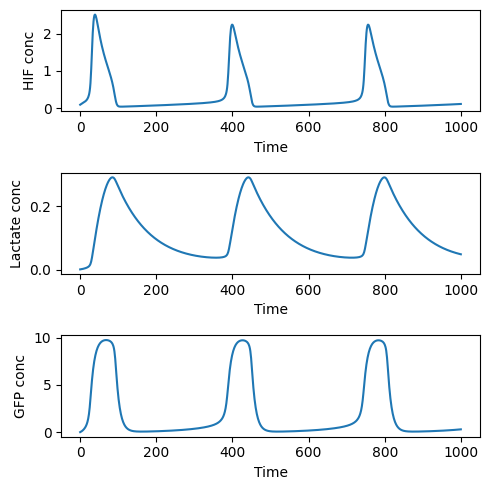

In [49]:
plot_ode_solution(t, solution)

In [50]:
def plot_ode_solution_with_parameters(
    k_HIF_production_basal, 
    k_HIF_production_max, 
    k_HIF_pos_feedback,
    k_HIF_deg_basal, 
    k_HIF_deg_lactate, 
    k_lactate_production,
    k_lactate_production_reg, 
    k_lactate_deg_basal,
    k_GFP_production_constantFP_production, 
    k_GFP_production_constant,
    k_GFP_deg, 
    k_MCT1, 
    k_MCT4, 
    o2_response_scaling,
    kmax_o2_deg, 
    k_min_o2_deg, 
    total_time=1000
):
    conc_conversion_oxygen = 1
    conc_conversion_lactate = 1
    
    # Define the ODE system inside or make sure it's accessible
    # Define initial conditions and time array based on total_time
    y0 = [0.1, 0.001, 0.0, 1.1, 0.1]  # Example initial conditions
    t = np.linspace(0, total_time, int(total_time))  # Time array

    # Solve the ODE system with the current parameters
    solution = odeint(system_of_odes, y0, t, args=(
        k_HIF_production_basal, k_HIF_production_max, k_HIF_pos_feedback,
        k_HIF_deg_basal, k_HIF_deg_lactate, k_lactate_production,
        k_lactate_production_reg, k_lactate_deg_basal,
        k_GFP_production_constantFP_production, k_GFP_production_constant,
        k_GFP_deg, k_MCT1, k_MCT4, o2_response_scaling,
        kmax_o2_deg, k_min_o2_deg, conc_conversion_oxygen,
        conc_conversion_lactate
    ))
    
    # Plot the results (assuming the plot_ode_solution function takes the solution and plots it)
    # plt.figure(figsize=(8, 4))
    plot_ode_solution(t, solution)
    # plt.show()


In [51]:
# Custom layout for the sliders
slider_layout = Layout(width='500px', height='20px')
label_layout = Layout(width='250px')

# Function to create a FloatSlider with custom layout
def custom_float_slider(description, min, max, step, value):
    return FloatSlider(
        value=value,
        min=min,
        max=max,
        step=step,
        description=description,
        style={'description_width': 'initial'},  # This ensures the description text is not cut off
        layout=slider_layout,
        description_tooltip=description  # Adds a tooltip showing the full description
    )

In [55]:
interact(plot_ode_solution_with_parameters,
         k_HIF_production_basal=custom_float_slider('k_HIF_prod_basal', 0.0, 0.1, 0.001, 0.02),
         k_HIF_production_max=custom_float_slider('k_HIF_production_max', 0.0, 2.0, 0.01, 0.9),
         k_HIF_pos_feedback=custom_float_slider('k_HIF_pos_feedback', 0.0, 10.0, 0.1, 1),
         k_HIF_deg_basal=custom_float_slider('k_HIF_deg_basal', 0.0, 1.0, 0.01, 0.2),
         k_HIF_deg_lactate=custom_float_slider('k_HIF_deg_lactate', 0.0, 2.0, 0.01, 1),
         k_lactate_production=custom_float_slider('k_lactate_production', 0.0, 0.1, 0.001, 0.01),
         k_lactate_production_reg=custom_float_slider('k_lactate_production_reg', 0.0, 2.0, 0.1, 1),
         k_lactate_deg_basal=custom_float_slider('k_lactate_deg_basal', 0.0, 0.1, 0.001, 0.01),
         k_GFP_production_constantFP_production=custom_float_slider('k_GFP_production_constantFP_production', 0.0, 2.0, 0.01, 1),
         k_GFP_production_constant=custom_float_slider('k_GFP_production_constant', 0.0, 0.1, 0.001, 0.05),
         k_GFP_deg=custom_float_slider('k_GFP_deg', 0.0, 0.5, 0.01, 0.1),
         k_MCT1=custom_float_slider('k_MCT1', 0.0, 0.01, 1E-4, 1E-3),
         k_MCT4=custom_float_slider('k_MCT4', 0.0, 0.01, 1E-4, 1E-3),
         o2_response_scaling=custom_float_slider('o2_response_scaling', 0.0, 2.0, 0.1, 1.0),
         kmax_o2_deg=custom_float_slider('kmax_o2_deg', 0.0, 0.5, 0.01, 1e-1),
         k_min_o2_deg=custom_float_slider('k_min_o2_deg', 0.0, 0.1, 0.001, 1e-2),
         total_time=custom_float_slider('Total Time', 10, 2000, 10, 1000)
        )

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_67958/3468196994.py:7: DeprecationWarning: the description_tooltip argument is deprecated, use tooltip instead
  return FloatSlider(


interactive(children=(FloatSlider(value=0.02, description='k_HIF_prod_basal', layout=Layout(height='20px', wid…

<function __main__.plot_ode_solution_with_parameters(k_HIF_production_basal, k_HIF_production_max, k_HIF_pos_feedback, k_HIF_deg_basal, k_HIF_deg_lactate, k_lactate_production, k_lactate_production_reg, k_lactate_deg_basal, k_GFP_production_constantFP_production, k_GFP_production_constant, k_GFP_deg, k_MCT1, k_MCT4, o2_response_scaling, kmax_o2_deg, k_min_o2_deg, total_time=1000)>